In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from micrograd_plus.engine import Value
from micrograd_plus.nn import MLP

In [8]:
# generate two blobs of data points and mutate y to be 1 or -1
X, y = make_blobs(n_samples=100, centers = 2)
y = y*2 - 1 

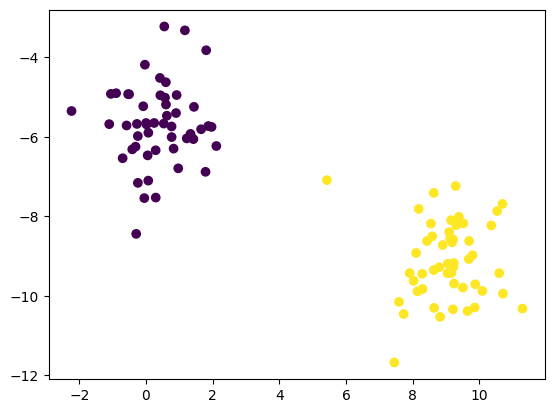

In [9]:
# visualizing the data
plt.scatter(X[:, 0], X[:, 1], c = y)

In [4]:
# initialize a 2 layer neural network with 2 input neurons and 1 output neuron
model = MLP(2, [16, 16, 1]) 

number of parameters 337


In [5]:
# define the loss function
def loss(batch_size=None):
    # dataloader
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    scores = list(map(model, inputs))
    
    # hinge loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # regularization to reduce overfitting
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

In [6]:
# training the neural network
for k in range(100):
    # forward pass
    total_loss, acc = loss()
    
    # backward pass (calculate grads)
    model.zero_grad()
    total_loss.backward()
    
    # gradient descent 
    learning_rate = 1.0 - 0.9*k/100 # adaptive learning rate, makes descent less steep on later passes
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    # print pass no. and accuracy
    if (k + 1) == 1 or (k + 1) % 10 == 0:
        print(f"step {k + 1} loss {total_loss.data}, accuracy {acc*100}%")
    
    # end loop if accuracy reaches 100%
    if acc == 1:
        break

step 1 loss 0.9294942657164973, accuracy 50.0%


(-4.47219400956436, 5.02780599043564)

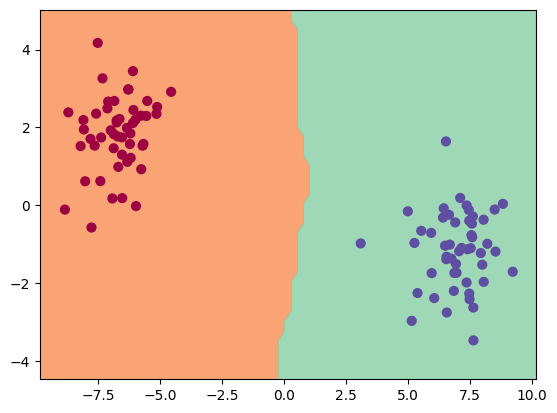

In [7]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())